In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math

from sklearn.cluster import KMeans
from scipy.special import factorial
from scipy.stats import poisson

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

%matplotlib inline

The idea is to buid a HMM model that infers state changes during chemotaxis. I expect to capture state transitions during chemotaxis and non-stationarity over optogenetic stimulations.

An extention to GLM-HMM and input-driven AR-HMM would be ideal to capture sensory-guided behavior that is both switching and continously driven by input.

The following test codes follows the PRML book and Sarah's matalb code...

(3, 1000)

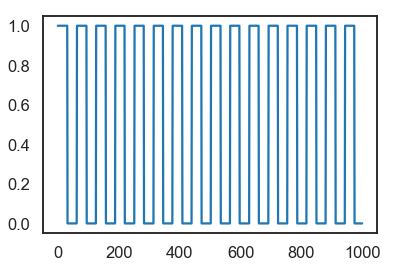

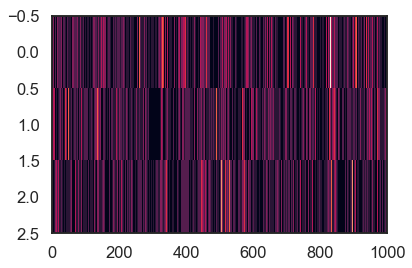

In [120]:
##simple simulation state-modulated Poisson process
#parameters
# X = np.random.randi(4,1000)  #data (4X1000 for example eigen worm time series)
#X = np.random.randint(5, size=(4,1000))
N = 3   #observations  (eigen worms)
T = 1000  #time series
nstates = 2  #number of states

xx = np.arange(0,T)
zz = np.sin(xx/10)
zz[zz>=0] = 1
#pos = np.intersect1d(np.where(zz<1)[0],np.where(zz>-0.5)[0])
#zz[pos]=2
zz[zz<=0] = 0
plt.plot(zz)

X = []
for ii in range(0,N):
    pp = np.zeros(T)
    pos = np.where(zz==0)[0]
    pp[pos] = np.random.poisson(1,size=(len(pos)))
    pos = np.where(zz==1)[0]
    pp[pos] = np.random.poisson(2,size=(len(pos)))
    X.append(pp)#*zz)

plt.figure()
plt.imshow(X,aspect='auto')
X = np.array(X)
X.shape

In [166]:
np.sum(np.random.randn(2,3),axis=0)

array([ 1.26730712, -1.56958968, -0.60699797])

In [192]:
###Test with HMM modulated Poisson process

#input fake data initialization
maxiter = 50  #iterations of update
tol = 0.000  #tolerance of error

pi = np.ones(nstates)/nstates  #initial distribution
A = np.ones((nstates,nstates))/nstates**2  #initial transition matrix
temp = np.random.rand(nstates,nstates)
A = temp/np.sum(temp)

#initialize emitted clusters
kmeans = KMeans(n_clusters=nstates, random_state=0).fit(X.T)   #initialize with k-means
temp = kmeans.labels_
labels = np.zeros((T,nstates))
for tt in range(0,T):
    labels[tt,temp[tt]] = 1   #identifying transition in the time series

#initialize emission paramter (Poisson rate here)
lams = np.zeros((N,nstates))
for nn in range(0,N):
    lams[nn,:] = np.matmul(X[nn,:],labels)/np.sum(labels,axis=0)  #initialize with mean count

#log-likelihood
LL_train = np.empty(maxiter)
dLL = 1
ii = 0

#Update iteration
while ii<maxiter-1:
    ##### forward recursion #####
    #initialization
    alphas = np.zeros((T,nstates))  #forward pass alphas
    px_z = np.zeros((T,nstates))    #data likelihood (probability of x given k)
    c = np.zeros(T)                 #variable to store marginal
    
    #px_z[0,:] = np.exp( np.nansum(-lams + np.matmul(X[:,0],np.log(lams)) - np.log(math.factorial(X[:,0]))) )  
    px_z[0,:] = 1*np.exp( np.nansum(-lams + np.repeat(X[:,0][:,None],nstates,axis=1)*np.log(lams) 
                                    - np.repeat(np.log(factorial(X[:,0]))[:,None],nstates,axis=1),axis=0) ) 
    #Poisson rate, should change to GLM (!!!???)
    
    alphas[0,:] = pi*px_z[0,:]          #initial alpha, equation 13.37 
    c[0] = np.sum(alphas[0,:]);         #store marginal likelihood
    alphas[0,:] = alphas[0,:]/c[0]      #normalize 13.59
    
    #iterate of alpha
    for tt in range(1,T):
        #p(x|z)(n,:) = prod(exp(-lambdas).*lambdas.^spikes(:,n)./fac_spikes(:,n))
        ###px_k(1,:) = exp(nansum(-lambdas + spikes(:,1).*log(lambdas) - log(fac_spikes(:,1))));
        temp = np.exp( np.nansum(-lams + np.repeat(X[:,tt][:,None],nstates,axis=1)*np.log(lams) 
                              - np.repeat(np.log(factorial(X[:,tt]))[:,None],nstates,axis=1),axis=0) ) 
        px_z[tt,:] = temp#/np.sum(temp)
        alphas[tt,:] = px_z[tt,:]*np.sum(alphas[tt-1,:]*A,axis=1)   # equation 13.36  
    
        c[tt] = np.sum(alphas[tt,:]);                        # marginal likelihood
        alphas[tt,:] = alphas[tt,:]/np.sum(alphas[tt,:])     # normalize 13.59
        
    LL_train[ii] = np.sum(np.log(c));                          #store log-likelihood
    if ii>0:
        dLL = LL_train[ii] - LL_train[ii-1]      #compute difference if >1 iterations have occurred
        
    ##### backward recursion #####
    #initialization
    betas = np.zeros((T,nstates))    #backward passing beta
    betas[-1,:] = np.ones(nstates)/nstates   #inital beta (13.39)
    
    #iterate of beta
    backt = np.arange(T-2,-1,-1)
    for tt in backt:
        betas[tt,:] = np.sum(betas[tt+1,:]*px_z[tt+1,:]*A,axis=1) #equation  13.38 
        betas[tt,:] = betas[tt,:]/c[tt+1]                         #normalize 13.62
        
    ##### Update parameters #####
    #gamma - eq. 13.33
    temp = alphas*betas
    gammas = temp/np.repeat(np.sum(temp,axis=1)[:,None],nstates,axis=1)
    
    #xi - eq. 13.43
    xis = np.zeros((T-1,nstates,nstates))
    for tt in range(1,T):
        xis[tt-1,:,:] = alphas[tt-1,:]*px_z[tt,:]*A*betas[tt,:]
        xis[tt-1,:] = xis[tt-1,:]/np.sum(xis[tt-1,:])
    
    #initial state prob - eq. 13.18
    pi = gammas[0,:]/np.sum(gammas[0,:])
    
    #transition matrix  - eq. 12.19
    A = np.sum(xis,axis=0)#np.squeeze(np.sum(xis,axis=0))
    A = A/np.sum(A,axis=1)
    
    #emission probability - eq. 13.23
    for nn in range(0,N):
        lams[nn,:] = np.matmul(X[nn,:],gammas)/np.sum(gammas,axis=0)

    ii = ii + 1

49
-5.194924597162753e-07


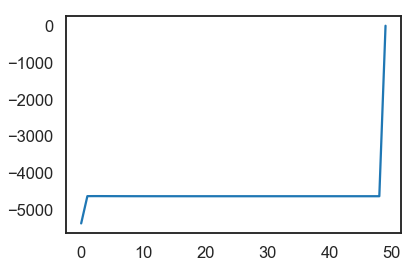

In [193]:
plt.plot(LL_train)
print(ii)
print(dLL)

Modified the Viterbi algorithm from this repository: https://github.com/nhchristianson/PoissonHMM

In [223]:
seq = X[0,:]
theta = np.log(A)
delta = np.log(pi)
lambdas = lams[0,:]

In [230]:
def _sp_lpmf(mean, val):
    if mean == -1:
        if val == -1:
            return 0
        else:
            return -np.inf
    elif mean >= 0:
        if val == -1:
            return -np.inf
        else:
            return poisson(mean).logpmf(val)

In [225]:
v_n = [0.0 for _ in range(nstates)]
vlst = [v_n]
wlst = []
for i in range(len(seq) - 1, 0, -1):
    v_i = []
    w_i = []
    for j in range(nstates):
        all_v_ij = []
        for k in range(nstates):
            temp = theta[j, k] + _sp_lpmf(lambdas[k], seq[i])
            temp += vlst[-1][k]
            all_v_ij.append(temp)
        v_i.append(max(all_v_ij))
        w_i.append(np.argmax(all_v_ij))
    vlst.append(v_i)
    wlst.append(w_i)
wlst.reverse()
first_prob = [_sp_lpmf(lambdas[i], seq[0]) for i in range(nstates)]
first_prob = np.add(first_prob, delta)
first_prob = np.add(first_prob, vlst[-1])
h_1 = np.argmax(first_prob)
statelst = [h_1]
for i in range(len(wlst)):
    statelst.append(wlst[i][statelst[-1]])


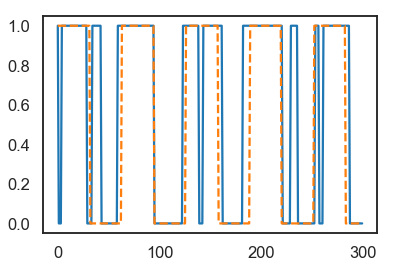

In [229]:
plt.plot(statelst[:300])
plt.plot(zz[:300],'--')

In [194]:
# def viterbi(y, A, B, Pi=None):
#     """
#     Return the MAP estimate of state trajectory of Hidden Markov Model.

#     Parameters
#     ----------
#     y : array (T,)
#         Observation state sequence. int dtype.
#     A : array (K, K)
#         State transition matrix. See HiddenMarkovModel.state_transition  for
#         details.
#     B : array (K, M)
#         Emission matrix. See HiddenMarkovModel.emission for details.
#     Pi: optional, (K,)
#         Initial state probabilities: Pi[i] is the probability x[0] == i. If
#         None, uniform initial distribution is assumed (Pi[:] == 1/K).

#     Returns
#     -------
#     x : array (T,)
#         Maximum a posteriori probability estimate of hidden state trajectory,
#         conditioned on observation sequence y under the model parameters A, B,
#         Pi.
#     T1: array (K, T)
#         the probability of the most likely path so far
#     T2: array (K, T)
#         the x_j-1 of the most likely path so far
#     """
#     # Cardinality of the state space
#     K = A.shape[0]
#     # Initialize the priors with default (uniform dist) if not given by caller
#     Pi = Pi if Pi is not None else np.full(K, 1 / K)
#     T = len(y)
#     T1 = np.empty((K, T), 'd')
#     T2 = np.empty((K, T), 'B')

#     # Initilaize the tracking tables from first observation
#     T1[:, 0] = Pi * B[:, y[0]]
#     T2[:, 0] = 0

#     # Iterate throught the observations updating the tracking tables
#     for i in range(1, T):
#         T1[:, i] = np.max(T1[:, i - 1] * A.T * B[np.newaxis, :, y[i]].T, 1)
#         T2[:, i] = np.argmax(T1[:, i - 1] * A.T, 1)

#     # Build the output, optimal model trajectory
#     x = np.empty(T, 'B')
#     x[-1] = np.argmax(T1[:, T - 1])
#     for i in reversed(range(1, T)):
#         x[i - 1] = T2[x[i], i]

#     return x, T1, T2

# sec = np.array(X[0,:],dtype=int)
# test_emit = labels[:,0]*1+labels[:,1]*2
# x,T1,T2 = viterbi(np.array(test_emit,dtype=int), A, lams.T,Pi=None)